### Libraries

- **os**: Used for file and directory operations.
- **random**: Used for generating random numbers and shuffling data.
- **numpy**: Used for numerical operations and array manipulations.
- **PIL (Python Imaging Library)**: Used for image processing; `Image` and `ImageOps` modules are used to work with images.
- **torch.utils.data**: Provides tools for data loading and splitting datasets during training, including `DataLoader` and `random_split`.
- **torchvision.datasets**: Provides easy access to popular datasets.
- **torchvision.transforms**: Used to apply transformations (such as rescaling, normalization) to image data.
- **torch**: The core PyTorch library used for deep learning tasks.
- **torch.nn**: Contains modules and classes for building neural network models.
- **torch.optim**: Contains optimization algorithms like SGD and Adam for model training.
- **matplotlib.pyplot**: Used for data visualization and plotting graphs.

In [1]:
import os
import random
import numpy as np
from PIL import Image, ImageOps
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

### Parameters and Data Augmentation Pipeline

#### Parameters:
- **input_dir**: Path to the directory containing the original dataset (JPEG images). In this case, it points to the "Animals with Attributes 2" dataset.
- **output_dir**: Path to the directory where the augmented dataset will be saved after processing.
- **target_count**: The target number of images to be generated per class after augmentation (set to 1000 images per class).
- **min_size**: Minimum size for resizing images, set to 128x128 pixels.

#### Data Augmentation Pipeline:
The following image transformations are applied to the dataset to augment it:

1. **RandomHorizontalFlip**: Randomly flips the image horizontally with a probability of 0.5.
2. **RandomRotation**: Rotates the image randomly by up to 10 degrees.
3. **ColorJitter**: Randomly changes the image's brightness and contrast with a factor of 0.5.
4. **RandomResizedCrop**: Randomly crops and resizes the image to the target size (128x128), with the crop scale ranging from 80% to 100%.
5. **RandomAffine**: Applies random affine transformations, including:
   - Rotation by up to 10 degrees.
   - Translation by up to 10% of the image dimensions.
   - Scaling by a factor ranging from 80% to 120%.
6. **RandomVerticalFlip**: Randomly flips the image vertically with a probability of 0.5.
7. **Resize**: Ensures that all images are resized to the final target size (128x128 pixels).
8. **ToTensor**: Converts the image into a tensor format, which is compatible with PyTorch for model training.


In [2]:
# Parameters
input_dir = "JPEGImages"  # Original dataset
output_dir = "augmented_dataset_128x128"  # Balanced dataset
target_count = 1000  # Target number of images per class
min_size = 128  # Minimum size
# Data augmentation pipeline
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(degrees=10),  # Random rotation by 10 degrees
    transforms.ColorJitter(brightness=0.5, contrast=0.5),  # Random color jitter
    transforms.RandomResizedCrop(size=(min_size, min_size), scale=(0.8, 1.0)),  # Random resize crop
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # Random affine transformation
    transforms.RandomVerticalFlip(p=0.5),  # Random vertical flip
    transforms.Resize((min_size, min_size)),  # Ensure image is resized to 128x128
    transforms.ToTensor(),  # Convert images to tensor
])

### Salt-and-Pepper Noise and Light Rotation Functions

#### Salt-and-Pepper Noise Function
This function introduces "salt-and-pepper" noise to an image:
- **Salt**: Random pixels are set to 255 (white).
- **Pepper**: Random pixels are set to 0 (black).
  
The noise is added at a specified amount, which defaults to 2% of the total pixels.

#### Light Rotation Function
Applies light rotation to an image by a random angle between -10° and 10°.

#### Data Augmentation Selection
Randomly applies one of the two augmentations: salt-and-pepper noise or light rotation.

### Data Processing and Augmentation

The following steps are performed for each class of images in the dataset:

1. **Directory Setup**: Creates output directories for each class if they don't exist.
2. **Image Handling**:
   - If a class contains more or equal to the target count of images, existing images are resized to 128x128 and saved.
   - If there are fewer than the target count, the script applies augmentations to make up the difference:
     - Randomly selects an image.
     - Applies random augmentations (either salt-and-pepper noise or light rotation).
     - Saves the augmented image in the class directory.

### Output Structure
The script processes images from the `input_dir`, resizes them to 128x128, applies augmentation if necessary, and stores the processed images in the `output_dir` under respective class folders.


In [3]:
# Salt-and-Pepper Noise Function
def salt_and_pepper_noise(image, amount=0.02):
    """ Add salt and pepper noise to an image """
    np_image = np.array(image)
    total_pixels = np_image.size
    num_salt = int(amount * total_pixels)
    num_pepper = int(amount * total_pixels)

    # Salt: set random pixels to 255 (white)
    salt_coords = [np.random.randint(0, i - 1, num_salt) for i in np_image.shape[:2]]
    np_image[salt_coords[0], salt_coords[1], :] = 255

    # Pepper: set random pixels to 0 (black)
    pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in np_image.shape[:2]]
    np_image[pepper_coords[0], pepper_coords[1], :] = 0

    return Image.fromarray(np_image)

# Light Rotation Function
def light_rotation(image):
    """ Apply light rotation (±10°) to an image """
    angle = random.uniform(-10, 10)  # Random rotation angle between -10 and 10 degrees
    return transforms.functional.rotate(image, angle)

# Data Augmentation Selection
def random_augmentation(image):
    """ Randomly apply one augmentation method """
    if random.random() < 0.5:
        return salt_and_pepper_noise(image)
    else:
        return light_rotation(image)

os.makedirs(output_dir, exist_ok=True)

# Process Classes
for class_name in sorted(os.listdir(input_dir)):
    class_dir = os.path.join(input_dir, class_name)
    output_class_dir = os.path.join(output_dir, class_name)
    os.makedirs(output_class_dir, exist_ok=True)

    images = os.listdir(class_dir)
    image_count = len(images)

    # If there are more than or equal to the target number of images, copy existing images
    if image_count >= target_count:
        selected_images = images[:target_count]
        for img_name in selected_images:
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path).convert("RGB")
            
            # Resize image to 128x128
            if img.size[0] > min_size and img.size[1] > min_size:
                img = transforms.Resize((min_size, min_size))(img)
            img.save(os.path.join(output_class_dir, img_name))
    
    # If there are fewer than the target number of images, apply augmentation
    else:
        augment_count = target_count - image_count
        for img_name in images:
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path).convert("RGB")
            
            # Resize image to 128x128
            if img.size[0] > min_size and img.size[1] > min_size:
                img = transforms.Resize((min_size, min_size))(img)
            img.save(os.path.join(output_class_dir, img_name))

        # Augment the remaining number of images
        for i in range(augment_count):
            img_name = random.choice(images)
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path).convert("RGB")
            
            # Apply random augmentation
            augmented_img = random_augmentation(img)
            
            # Save augmented image
            augmented_img.save(os.path.join(output_class_dir, f"aug_{i}_{img_name}"))


### Counting Images per Class

This section of the code counts the number of images per class in the output directory after data augmentation.

#### Code Explanation:

1. **class_counts**: An empty dictionary is initialized to store the count of images for each class.

2. **for class_name in sorted(os.listdir(output_dir))**: Iterates through each subdirectory (class) in the `output_dir`. The `sorted()` function ensures the classes are processed in a sorted order.

3. **class_dir = os.path.join(output_dir, class_name)**: Combines the output directory path with the class name to form the path to each class directory.

4. **if os.path.isdir(class_dir)**: Checks if the path refers to a directory, ensuring only directories (representing classes) are processed.

5. **image_count = len(os.listdir(class_dir))**: Counts the number of files (images) inside the class directory.

6. **class_counts[class_name] = image_count**: Stores the image count for the current class in the `class_counts` dictionary.

7. **for class_name, count in class_counts.items()**: Loops through each class and its corresponding image count in the `class_counts` dictionary, printing the class name and its image count.

8. **total_images = sum(class_counts.values())**: Sums up the image counts across all classes to get the total number of images in the dataset.

9. **print(f"Total Image Count: {total_images}")**: Prints the total number of images across all classes.

#### Output:
The script outputs the number of images per class, followed by the total number of images in the augmented dataset.


In [4]:
class_counts = {}
for class_name in sorted(os.listdir(output_dir)):
    class_dir = os.path.join(output_dir, class_name)
    
    if os.path.isdir(class_dir):
        image_count = len(os.listdir(class_dir))
        class_counts[class_name] = image_count

for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Image Count: {count}")

total_images = sum(class_counts.values())
print(f"Total Image Count: {total_images}")

Class: antelope, Image Count: 1000
Class: bat, Image Count: 1000
Class: beaver, Image Count: 1000
Class: blue+whale, Image Count: 1000
Class: bobcat, Image Count: 1000
Class: buffalo, Image Count: 1000
Class: chihuahua, Image Count: 1000
Class: chimpanzee, Image Count: 1000
Class: collie, Image Count: 1000
Class: cow, Image Count: 1000
Class: dalmatian, Image Count: 1000
Class: deer, Image Count: 1000
Class: dolphin, Image Count: 1000
Class: elephant, Image Count: 1000
Class: fox, Image Count: 1000
Class: german+shepherd, Image Count: 1000
Class: giant+panda, Image Count: 1000
Class: giraffe, Image Count: 1000
Class: gorilla, Image Count: 1000
Class: grizzly+bear, Image Count: 1000
Class: hamster, Image Count: 1000
Class: hippopotamus, Image Count: 1000
Class: horse, Image Count: 1000
Class: humpback+whale, Image Count: 1000
Class: killer+whale, Image Count: 1000
Class: leopard, Image Count: 1000
Class: lion, Image Count: 1000
Class: mole, Image Count: 1000
Class: moose, Image Count: 1

### Identifying and Listing Images Smaller than 128x128

This script checks for images in the dataset that are smaller than 128x128 pixels and lists them.

#### Code Explanation:

1. **small_images**: An empty list is initialized to store information about images that are smaller than 128x128 pixels (including class, image name, width, and height).

2. **for class_name in sorted(os.listdir(output_dir))**: The script iterates through the directories (representing different classes) inside the `output_dir`, sorting them alphabetically to ensure consistency.

3. **class_dir = os.path.join(output_dir, class_name)**: Combines the `output_dir` with the current class name to create the full path to the class directory.

4. **if os.path.isdir(class_dir)**: Ensures that only directories are processed, skipping any non-directory files in the output directory.

5. **for img_name in os.listdir(class_dir)**: Iterates through the files (images) within each class directory.

6. **img_path = os.path.join(class_dir, img_name)**: Combines the class directory path with the image filename to get the full image path.

7. **img = Image.open(img_path).convert("RGB")**: Opens the image and converts it to RGB format to ensure consistent color channels.

8. **if img.size[0] < min_size or img.size[1] < min_size**: Checks if the width (`img.size[0]`) or height (`img.size[1]`) of the image is smaller than the `min_size` (128 pixels). If either dimension is smaller, it qualifies as a "small" image.

9. **small_images.append((class_name, img_name, img.size[0], img.size[1]))**: If an image is smaller than 128x128 pixels, its class name, image name, and dimensions (width and height) are appended to the `small_images` list.

10. **except Exception as e**: Catches and handles any errors that occur when trying to open or process an image, and prints an error message indicating which image caused the issue.

11. **if small_images**: After processing all images, the script checks if there are any images in the `small_images` list. If so, it proceeds to print details about each image (class name, image name, width, and height).

12. **else**: If no images smaller than 128x128 are found, it prints a message confirming that all images are at least 128x128 pixels.

#### Output:
- If there are any images smaller than 128x128, the script will print the number of such images, along with their class name, image name, and dimensions (width x height).
- If all images meet the size requirement, a confirmation message stating "All images are 128x128 or larger." will be displayed.


In [5]:
# List to hold images smaller than 128x128
small_images = []

# Check all images
for class_name in sorted(os.listdir(output_dir)):
    class_dir = os.path.join(output_dir, class_name)

    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = Image.open(img_path).convert("RGB")
                
                # Size check: If the size is smaller than 128x128
                if img.size[0] < min_size or img.size[1] < min_size:
                    small_images.append((class_name, img_name, img.size[0], img.size[1]))
            except Exception as e:
                print(f"Error occurred: {img_path} - {e}")

# Images smaller than 128x128
if small_images:
    print(f"{len(small_images)} images are smaller than 128x128:")
    for class_name, img_name, width, height in small_images:
        print(f"Class: {class_name}, Image: {img_name}, Size: {width}x{height}")
else:
    print("All images are 128x128 or larger.")

4 images are smaller than 128x128:
Class: deer, Image: deer_10356.jpg, Size: 500x122
Class: dolphin, Image: dolphin_10885.jpg, Size: 170x127
Class: squirrel, Image: squirrel_10722.jpg, Size: 100x100
Class: squirrel, Image: squirrel_10744.jpg, Size: 120x160


### Padding Images to 128x128

This script pads images that are smaller than 128x128 pixels to the required size of 128x128 pixels. It ensures that images are centered with black padding.

#### Code Explanation:

1. **pad_to_128(img)**: A function that adds padding to an image to resize it to 128x128 pixels if its dimensions are smaller than the target size.
   - **width, height = img.size**: Retrieves the current width and height of the image.
   - **if width < min_size or height < min_size**: Checks if either the width or height is smaller than the specified `min_size` (128 pixels).
   - **padding_left, padding_top, padding_right, padding_bottom**: Calculates how much padding is needed on each side (left, top, right, bottom) to center the image and reach the required 128x128 size.
   - **img = ImageOps.expand(img, (padding_left, padding_top, padding_right, padding_bottom), fill=(0, 0, 0))**: Adds the calculated padding around the image. The `fill=(0, 0, 0)` ensures that the padding is black (RGB color (0, 0, 0)).

2. **for class_name, img_name, width, height in small_images**: Loops through the `small_images` list, which contains information about images smaller than 128x128 pixels.
   
3. **img_path = os.path.join(output_dir, class_name, img_name)**: Combines the class directory and image name to form the full path to each image.

4. **img = Image.open(img_path).convert("RGB")**: Opens the image and converts it to RGB format.

5. **img = pad_to_128(img)**: Applies the padding function to resize the image to 128x128 pixels, if necessary.

6. **img.save(img_path)**: Saves the padded image, overwriting the original image.

7. **print(f"Class: {class_name}, Image: {img_name} - Size: {img.size} (padding applied)")**: Prints the class name, image name, and the new size of the image after padding.

8. **except Exception as e**: Catches and handles any errors that occur while processing an image, printing an error message.

9. **print("Padding process completed.")**: Prints a message indicating the completion of the padding process.

#### Output:
- For each image that is smaller than 128x128, the script prints the class name, image name, and the new size of the image after padding.
- If any errors occur during image processing, the error message is printed.
- A final message "Padding process completed." is printed when the script finishes.


In [6]:
# Padding function: Resize the image to 128x128
def pad_to_128(img):
    # Current image dimensions
    width, height = img.size
    
    # Only add padding to images smaller than the required size
    if width < min_size or height < min_size:
        # Add padding to the right and bottom based on the image size
        padding_left = (min_size - width) // 2
        padding_top = (min_size - height) // 2
        padding_right = min_size - width - padding_left
        padding_bottom = min_size - height - padding_top
        
        img = ImageOps.expand(img, (padding_left, padding_top, padding_right, padding_bottom), fill=(0, 0, 0))
    
    return img

# Apply padding to the images in the small_images list
for class_name, img_name, width, height in small_images:
    img_path = os.path.join(output_dir, class_name, img_name)
    
    try:
        img = Image.open(img_path).convert("RGB")
        
        # Apply padding and save
        img = pad_to_128(img)
        img.save(img_path)  # Save the modified image
        print(f"Class: {class_name}, Image: {img_name} - Size: {img.size} (padding applied)")
    except Exception as e:
        print(f"Error occurred: {img_path} - {e}")

print("Padding process completed.")

Class: deer, Image: deer_10356.jpg - Size: (128, 128) (padding applied)
Class: dolphin, Image: dolphin_10885.jpg - Size: (128, 128) (padding applied)
Class: squirrel, Image: squirrel_10722.jpg - Size: (128, 128) (padding applied)
Class: squirrel, Image: squirrel_10744.jpg - Size: (128, 128) (padding applied)
Padding process completed.


### Identifying and Listing Images Larger than 128x128

This script identifies images in the dataset that are larger than 128x128 pixels and lists them.

#### Code Explanation:

1. **target_size = (128, 128)**: Defines the target size (128x128 pixels) that the images should not exceed.

2. **larger_images**: An empty list is initialized to store information about images that are larger than 128x128 pixels (including class, image name, width, and height).

3. **for class_name in sorted(os.listdir(output_dir))**: Iterates through the directories (representing different classes) inside the `output_dir`, sorting them alphabetically.

4. **class_dir = os.path.join(output_dir, class_name)**: Combines the `output_dir` with the current class name to create the path to the class directory.

5. **if os.path.isdir(class_dir)**: Ensures that only directories are processed, ignoring any non-directory files.

6. **for img_name in os.listdir(class_dir)**: Iterates through the images inside the current class directory.

7. **img_path = os.path.join(class_dir, img_name)**: Combines the class directory path and the image name to form the full image path.

8. **img = Image.open(img_path).convert("RGB")**: Opens the image and converts it to RGB format.

9. **if img.size[0] > target_size[0] or img.size[1] > target_size[1]**: Checks if the width (`img.size[0]`) or height (`img.size[1]`) of the image is larger than the defined `target_size` (128x128 pixels).

10. **larger_images.append((class_name, img_name, img.size[0], img.size[1]))**: If the image is larger than 128x128 pixels, the class name, image name, and dimensions are added to the `larger_images` list.

11. **except Exception as e**: Catches any errors that occur while processing an image, printing an error message.

12. **if larger_images**: If there are any images larger than 128x128, the script prints the total count of such images.

13. **else**: If no images are found that exceed the target size, the script prints a message saying "No images are larger than 128x128."

#### Output:
- If there are any images larger than 128x128, the script will print the total number of such images. 
- (Commented out) The code includes a `for` loop (currently commented) that can be used to print the class name, image name, and size of each large image.
- If no images are larger than 128x128, a message will state that all images are within the desired size limit.

In [7]:
target_size = (128, 128)  # Target size (128x128)

# List to store images that are larger than 128x128
larger_images = []

# Check all images
for class_name in sorted(os.listdir(output_dir)):
    class_dir = os.path.join(output_dir, class_name)

    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = Image.open(img_path).convert("RGB")
                
                # Size check: If the size is larger than 128x128
                if img.size[0] > target_size[0] or img.size[1] > target_size[1]:
                    larger_images.append((class_name, img_name, img.size[0], img.size[1]))
            except Exception as e:
                print(f"Error occurred: {img_path} - {e}")

# Images larger than 128x128
if larger_images:
    print(f"{len(larger_images)} images are larger than 128x128:")
    #for class_name, img_name, width, height in larger_images:
        #print(f"Class: {class_name}, Image: {img_name}, Size: {width}x{height}")
        # Run this for loop to see which images are large.
else:
    print("No images are larger than 128x128.")

15249 images are larger than 128x128:


### Resizing Images Larger than 128x128

This script resizes images that are larger than 128x128 pixels to the target size of 128x128 pixels using high-quality downsampling.

#### Code Explanation:

1. **for class_name, img_name, width, height in larger_images**: Loops through the list `larger_images`, which contains information about images larger than 128x128 pixels (class, image name, width, and height).

2. **img_path = os.path.join(output_dir, class_name, img_name)**: Combines the `output_dir` with the class name and image name to create the full path to each image.

3. **img = Image.open(img_path).convert("RGB")**: Opens the image and converts it to RGB format to ensure consistent color channels.

4. **img_resized = img.resize(target_size, Image.Resampling.LANCZOS)**: Resizes the image to the target size (128x128) using the `LANCZOS` filter, which is known for high-quality downsampling.

5. **img_resized.save(img_path)**: Saves the resized image back to the original path, overwriting the original image with the resized version.

6. **except Exception as e**: Catches any errors that occur during the resizing process and prints an error message with the image path and the error details.

7. **print("Resizing process completed.")**: After all images have been processed, a message is printed indicating that the resizing process has been completed.

#### Output:
- The script will resize any images in the `larger_images` list that exceed 128x128 pixels and save them back to their original paths.
- If an error occurs while resizing any image, an error message is printed.
- A final message "Resizing process completed." is printed when the script finishes processing all images.


In [8]:
# Resize images in the larger_images list
for class_name, img_name, width, height in larger_images:
    img_path = os.path.join(output_dir, class_name, img_name)
    try:
        img = Image.open(img_path).convert("RGB")
        
        # Resize the image to 128x128
        img_resized = img.resize(target_size, Image.Resampling.LANCZOS)  # Use high-quality downsampling
        
        # Save the resized image
        img_resized.save(img_path)
        #print(f"Class: {class_name}, Image: {img_name} - Resized to 128x128")
    except Exception as e:
        print(f"Error occurred during resizing: {img_path} - {e}")

print("Resizing process completed.")

Resizing process completed.


### Identifying Images Not Matching 128x128 Size

This script checks for images that do not match the target size of 128x128 pixels and lists them.

#### Code Explanation:

1. **non_matching_images**: An empty list is initialized to store information about images that do not match the target size of 128x128 pixels (including class, image name, width, and height).

2. **for class_name in sorted(os.listdir(output_dir))**: The script iterates through the directories (representing different classes) inside the `output_dir`, sorting them alphabetically.

3. **class_dir = os.path.join(output_dir, class_name)**: Combines the `output_dir` with the current class name to create the path to the class directory.

4. **if os.path.isdir(class_dir)**: Ensures that only directories are processed, ignoring any non-directory files in the output directory.

5. **for img_name in os.listdir(class_dir)**: Iterates through the images inside the current class directory.

6. **img_path = os.path.join(class_dir, img_name)**: Combines the class directory path and the image name to form the full image path.

7. **img = Image.open(img_path).convert("RGB")**: Opens the image and converts it to RGB format to ensure consistent color channels.

8. **if img.size != target_size**: Checks if the image size does not match the target size (128x128 pixels). If the size does not match, the image details are added to the `non_matching_images` list.

9. **non_matching_images.append((class_name, img_name, img.size[0], img.size[1]))**: If the image size is not 128x128, the class name, image name, and dimensions are appended to the list.

10. **except Exception as e**: Catches any errors that occur while processing an image, printing an error message with the image path and the error details.

11. **if non_matching_images**: If there are any images in the `non_matching_images` list, the script prints the total number of such images, along with their class name, image name, and dimensions (width and height).

12. **else**: If all images match the target size of 128x128, the script prints a message stating that all images are 128x128.

#### Output:
- If there are images that do not match the 128x128 size, the script prints the total number of such images, along with details about their class, image name, and size.
- If no images are found that deviate from the 128x128 size, a message stating "All images are 128x128 in size." will be printed.


In [9]:
# List to store images that do not match the 128x128 size
non_matching_images = []

# Check all images
for class_name in sorted(os.listdir(output_dir)):
    class_dir = os.path.join(output_dir, class_name)

    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = Image.open(img_path).convert("RGB")
                
                # Size check: If the size is not equal to 128x128
                if img.size != target_size:
                    non_matching_images.append((class_name, img_name, img.size[0], img.size[1]))
            except Exception as e:
                print(f"Error occurred: {img_path} - {e}")

# Images not matching the 128x128 size
if non_matching_images:
    print(f"{len(non_matching_images)} images are not 128x128:")
    for class_name, img_name, width, height in non_matching_images:
        print(f"Class: {class_name}, Image: {img_name}, Size: {width}x{height}")
else:
    print("All images are 128x128 in size.")

All images are 128x128 in size.


### Training Parameters

This section defines the key hyperparameters used for training a model using PyTorch.

#### Parameters:

1. **batch_size = 32**: 
   - Defines the number of samples that will be processed together in one batch during training. 
   - A batch size of 32 means that 32 images will be passed through the model at each training step.

2. **num_epochs = 10**: 
   - Specifies the number of times the entire training dataset will be passed through the model during training. 
   - A value of 10 means the model will be trained for 10 full iterations over the dataset.

3. **learning_rate = 0.001**: 
   - A learning rate of 0.001 is commonly used and determines how much the model weights will be updated after each batch. A smaller value can lead to more stable training but may take longer to converge, while a larger value can speed up training but might cause the model to overshoot the optimal weights.


In [10]:
# Parameters
batch_size = 32  # Batch size for DataLoader
num_epochs = 10  # Number of epochs
learning_rate = 0.001

### Transform for Data Loading

- **Purpose**: Converts images to tensors for compatibility with PyTorch models.
- **Transformation**:
  - **ToTensor()**: Converts PIL images or numpy arrays to PyTorch tensors, normalizing pixel values to the range [0, 1].

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL images to tensors
])

### Loading the Dataset

- **datasets.ImageFolder**: Loads the dataset from `output_dir`, assuming a folder-per-class structure.
- **transform**: Applies the specified transformations during loading.
- Assumes images are already resized to 128x128; no additional resizing needed.

In [12]:
# Load the dataset (already resized to 128x128, no need for further resize)
dataset = datasets.ImageFolder(root=output_dir, transform=transform)

### Splitting the Dataset

- **train_size**: 70% of the dataset is allocated for training.
- **test_size**: Remaining 30% is used for testing.
- **random_split**: Randomly divides the dataset into training and testing subsets based on the calculated sizes.

In [13]:
# Split dataset into 70% training and 30% testing
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

### Creating DataLoaders

- **train_loader**: Loads the training dataset with shuffling for randomness and uses the specified `batch_size`.
- **test_loader**: Loads the testing dataset without shuffling, ensuring data order is preserved.

In [14]:
# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Defining the CNN Model

- **Architecture**:
  - **Convolutional Layers**:
    - `conv1`, `conv2`, `conv3`: Extract features using 32, 64, and 128 filters with 3x3 kernels.
  - **Pooling**: Max pooling with a 2x2 window reduces spatial dimensions.
  - **Fully Connected Layers**:
    - `fc1`: Maps flattened features to 512 neurons.
    - `fc2`: Maps to the number of classes (`num_classes`).
  - **Dropout**: Applies 50% dropout after `fc1` for regularization.
  
- **Activation**: ReLU activation function is used in all layers.
- **Forward Pass**: Processes input through convolutional, pooling, and fully connected layers.
- **Input Size**: Adjusted for 128x128 images.


In [15]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes=50):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adjusted for 128x128 input size
        self.fc2 = nn.Linear(512, num_classes)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Added dropout for regularization

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Flatten the tensor for fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout before the final layer
        x = self.fc2(x)
        return x

### Model Initialization and Device Setup

- **Model**: An instance of the `CNN` class is created with `num_classes=50`.
- **Device**: Checks for CUDA availability and selects `cuda` if available; otherwise, defaults to `cpu`.
- **Model to Device**: Moves the model to the selected device for training or inference.


In [16]:
# Initialize the model and move to CUDA if available
model = CNN(num_classes=50)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Optimizer and Loss Function

- **Optimizer**: Adam optimizer with a learning rate of `learning_rate` for efficient gradient updates.
- **Loss Function**: Cross-Entropy Loss, suitable for multi-class classification tasks.

In [17]:
# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

### Model Training Function

#### **Functionality**:
- Trains the CNN model and evaluates its performance on both training and testing datasets.

#### **Steps**:
1. **Training Phase**:
   - Set the model to training mode: `model.train()`.
   - Perform forward pass, calculate loss, and backpropagate gradients.
   - Update model weights using the optimizer.
   - Compute training accuracy for each epoch.

2. **Evaluation Phase**:
   - Set the model to evaluation mode: `model.eval()`.
   - Disable gradient computation for efficiency: `with torch.no_grad()`.
   - Compute test accuracy after each epoch.

3. **Metrics**:
   - Logs training loss, training accuracy, and testing accuracy for each epoch.

4. **Outputs**:
   - Returns lists of training and testing accuracies across epochs for further analysis.

#### **Console Output**:
- Displays epoch-wise training loss, training accuracy, and test accuracy.


In [18]:
# Train the model
def train_model(model, train_loader, test_loader, num_epochs):
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        train_correct = 0
        train_total = 0
        train_loss = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero gradients from previous step
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Calculate train accuracy
        train_accuracy = (train_correct / train_total) * 100
        train_accuracies.append(train_accuracy)
        
        # Evaluate on test data
        model.eval()  # Set model to evaluation mode
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():  # No gradients are needed during evaluation
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                
                # Calculate test accuracy
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        
        test_accuracy = (test_correct / test_total) * 100
        test_accuracies.append(test_accuracy)
        
        # Print the results for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Test Accuracy: {test_accuracy:.2f}%")
    
    return train_accuracies, test_accuracies

### Training the Model

- **Function Call**: `train_model` is invoked to train the model and compute accuracies.
- **Inputs**:
  - `model`: Initialized CNN model.
  - `train_loader` and `test_loader`: DataLoaders for training and testing datasets.
  - `num_epochs`: Number of epochs for training.
- **Outputs**:
  - `train_accuracies`: List of training accuracies over all epochs.
  - `test_accuracies`: List of testing accuracies over all epochs.

In [19]:
# Call the function to train and get accuracies
train_accuracies, test_accuracies = train_model(model, train_loader, test_loader, num_epochs)

Epoch [1/10], Train Loss: 3.3048, Train Accuracy: 13.64%, Test Accuracy: 26.98%
Epoch [2/10], Train Loss: 2.5816, Train Accuracy: 29.65%, Test Accuracy: 37.83%
Epoch [3/10], Train Loss: 2.1542, Train Accuracy: 39.86%, Test Accuracy: 44.92%
Epoch [4/10], Train Loss: 1.7324, Train Accuracy: 50.79%, Test Accuracy: 50.36%
Epoch [5/10], Train Loss: 1.3732, Train Accuracy: 60.07%, Test Accuracy: 54.05%
Epoch [6/10], Train Loss: 1.0399, Train Accuracy: 69.09%, Test Accuracy: 55.11%
Epoch [7/10], Train Loss: 0.8066, Train Accuracy: 75.56%, Test Accuracy: 57.11%
Epoch [8/10], Train Loss: 0.6239, Train Accuracy: 80.71%, Test Accuracy: 58.13%
Epoch [9/10], Train Loss: 0.5134, Train Accuracy: 84.15%, Test Accuracy: 58.19%
Epoch [10/10], Train Loss: 0.4413, Train Accuracy: 86.03%, Test Accuracy: 58.37%


### Plotting Train and Test Accuracies

- **Visualization**:
  - Plots training and testing accuracies across epochs to evaluate model performance.
  
- **Details**:
  - X-axis: Epochs.
  - Y-axis: Accuracy (percentage).
  - **Markers**:
    - `Train Accuracy`: Circles (`'o'`).
    - `Test Accuracy`: Crosses (`'x'`).
  - Includes a legend, grid, and labeled axes for clarity.

- **Purpose**:
  - Highlights how the model's performance evolves during training.
  - Helps identify overfitting or underfitting trends.


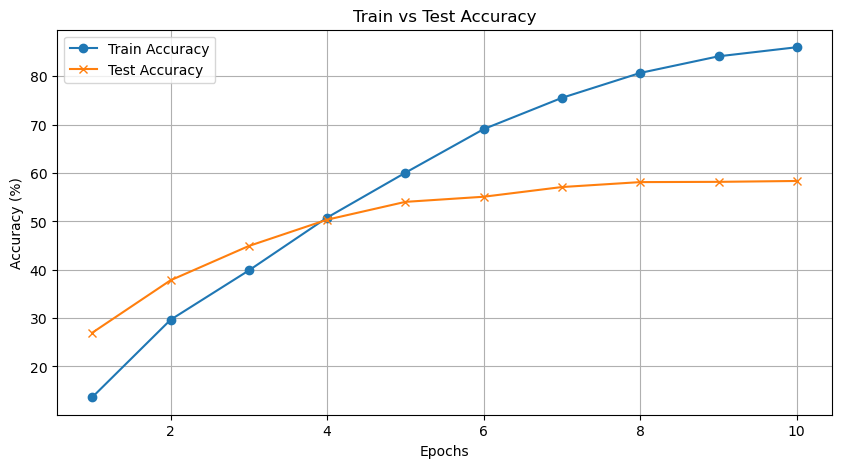

In [20]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), test_accuracies, label="Test Accuracy", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()